#### This is a simplest training pipeline

In [17]:
import argparse
import time
import os
import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, Dataset
from model_hyperbolic import GPT, GPTConfig  
import datetime

if torch.cuda.is_available():
    gpu_id = '3' # select a single GPU
    # gpu_id = '2,3' # select multiple GPUs
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
    device = torch.device("cuda")
    print('GPU name: {:s}, gpu_id: {:s}'.format(torch.cuda.get_device_name(0),gpu_id))

else:
    device = torch.device("cpu")
    gpu_id = -1 # select CPU

# Argument parsing
# parser = argparse.ArgumentParser(description="Train nanoGPT on Tao Te Ching")
# parser.add_argument("--batch_size", type=int, default=32, help="Batch size for training (default: 32)")
# parser.add_argument("--epochs", type=int, default=10, help="Number of epochs to train (default: 10)")
# parser.add_argument("--learning_rate", type=float, default=0.003, help="Learning rate (default: 0.003)")
# parser.add_argument("--block_size", type=int, default=32, help="Context size (default: 32)")
# parser.add_argument("--n_embd", type=int, default=16, help="Embedding dimension (default: 16)")
# parser.add_argument("--mode", type=str, default='original', help="Attention mode (default: original)")
args = dict(n_layer=6, 
            epochs = 100,
              n_head=8, 
              n_embd=16, 
              block_size=32, 
              batch_size=32, 
              bias=False, 
              dropout=0.0, 
              learning_rate=0.0003, 
              mode='original')
# Dataset preparation
class TaoTeChingDataset(Dataset):
    def __init__(self, data, chars, block_size):
        self.block_size = block_size
        self.stoi = {ch: i for i, ch in enumerate(chars)}
        self.itos = {i: ch for i, ch in enumerate(chars)}
        self.data = [self.stoi[ch] for ch in data]
        self.vocab_size = len(chars)

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        chunk = self.data[idx:idx + self.block_size + 1]
        dix = torch.tensor(chunk[:-1], dtype=torch.long)
        target = torch.tensor(chunk[1:], dtype=torch.long)
        return dix, target

# Load and preprocess text
with open('data/tao.txt', 'r', encoding='utf-8') as f:
    full_data = f.read()
chars = sorted(list(set(full_data)))
full_dataset = TaoTeChingDataset(full_data, chars, block_size=args['block_size'])

split_idx = int(len(full_data) * 0.9)

train_dataset = TaoTeChingDataset(full_data[:split_idx], chars, block_size=args['block_size'])
val_dataset = TaoTeChingDataset(full_data[split_idx:], chars, block_size=args['block_size'])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=args['batch_size'])
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=args['batch_size'])  

model_args = dict(n_layer=6, 
                  n_head=8, 
                  n_embd=16, 
                  block_size=args['block_size'], 
                  bias=False, 
                  vocab_size=full_dataset.vocab_size, 
                  dropout=0.0, 
                  mode=args['mode'])

model = GPT(GPTConfig(**model_args)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=args['learning_rate'])

            
with open('data/tao.txt', 'r', encoding='utf-8') as f:
    data = f.read()
    overfit_data = data[17:301]
    overfit_val_data = data[306:474]
    
overfit_dataset = TaoTeChingDataset(overfit_data, chars, block_size=args['block_size'])
overfit_loader = DataLoader(overfit_dataset, batch_size=args['batch_size'], shuffle=True)
    
overfit_val_dataset = TaoTeChingDataset(overfit_val_data, chars, block_size=args['block_size'])
overfit_val_loader = DataLoader(overfit_val_dataset, batch_size=args['batch_size'], shuffle=False)



# Training loop
def train(model, epoch, loader):
    model.train()
    train_loss = 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        _, loss = model(data, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
#         if idx % 100 == 0:
#             print(f"Epoch: {epoch} | Loss: {loss.item()}")
    train_loss = train_loss/len(loader)
    return train_loss
        
            
def evaluate(model, epoch, loader):
    model.eval()  
    val_loss = 0
    with torch.no_grad():  
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            _, loss = model(data, target)
            val_loss += loss.item()  
            
    val_loss /= len(loader) 
    return val_loss

def save_checkpoint(model, optimizer, model_args, train_losses, val_losses, out_dir, args):
    os.makedirs(out_dir, exist_ok=True)
    date_time_str = datetime.datetime.now().strftime("%m.%d, %H-%M")
    dim = args['n_embd']//args['n_head']
    mode = args['mode']
    filename = f"{date_time_str}, {dim}-dim, {mode} ckpt.pt"
    checkpoint = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'model_args': model_args,
        'train_losses': train_losses,
        'val_losses': val_losses,
    }
    torch.save(checkpoint, os.path.join(out_dir, filename))
#     print(f"Checkpoint saved to {filename}")

train_losses = []
val_losses = []
save_checkpoints = True
out_dir = 'out'

for epoch in range(1, args['epochs'] + 1):
    start_time = time.time()
    train_loss = train(model, epoch, overfit_loader)
    train_losses.append(train_loss)

    val_loss = evaluate(model, epoch, overfit_val_loader)
    val_losses.append(val_loss)
#     print(f"Epoch: {epoch} | Training Loss: {train_loss} | Validation Loss: {val_loss}")

    # Conditionally save checkpoints
    if save_checkpoints:
        save_checkpoint(model, optimizer, model_args, train_losses, val_losses, out_dir, args)

    end_time = time.time()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} completed in {end_time - start_time:.2f} seconds")

# print(overfit_val_data)

GPU name: Tesla V100-SXM2-16GB, gpu_id: 3
number of parameters: 0.02M
Entered Original mode
Entered Original mode
Entered Original mode
Entered Original mode
Entered Original mode
Entered Original mode
Epoch 10 completed in 0.28 seconds
Epoch 20 completed in 0.27 seconds
Epoch 30 completed in 0.27 seconds
Epoch 40 completed in 0.25 seconds
Epoch 50 completed in 0.23 seconds
Epoch 60 completed in 0.29 seconds
Epoch 70 completed in 0.25 seconds
Epoch 80 completed in 0.25 seconds
Epoch 90 completed in 0.23 seconds
Epoch 100 completed in 0.26 seconds


In [18]:
original_train_losses = train_losses
original_val_losses = val_losses

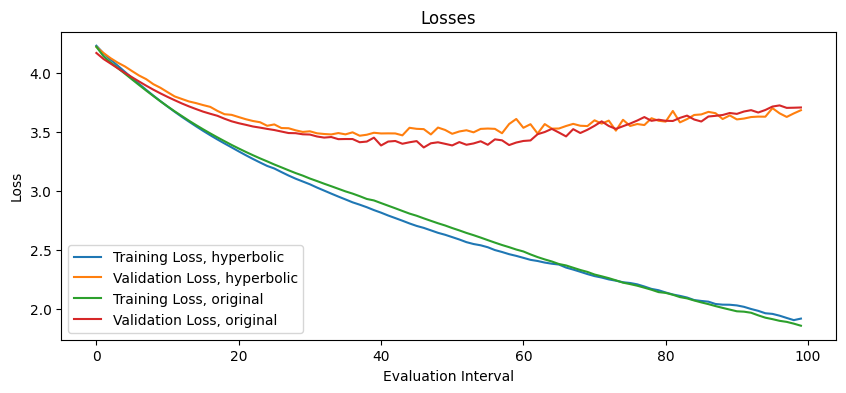

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(hyperbolic_train_losses, label='Training Loss, hyperbolic')
plt.plot(hyperbolic_val_losses, label='Validation Loss, hyperbolic')
plt.plot(original_train_losses, label='Training Loss, original')
plt.plot(original_val_losses, label='Validation Loss, original')
# plt.plot(train_losses_np2, label='Training Loss for a deeper net')
# plt.plot(val_losses2, label='Validation Loss, original')
plt.xlabel('Evaluation Interval')
plt.ylabel('Loss')
plt.title('Losses')
plt.legend()
plt.show()